In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import pathlib
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers
from keras import metrics
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import os

Using TensorFlow backend.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
K.floatx()

'float32'

In [4]:
conv_base = ResNet50(weights='imagenet', 
                     include_top=False,
                     input_shape=(224, 224, 3))
conv_base.summary()

/home/gxty/.conda/envs/keras_tensorflow_conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [5]:
def newSoftmax(x, axis=-1):
    ndim = K.ndim(x)
    if ndim >= 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D. '
                         'Received input: %s' % x)

In [6]:
average_pooling_layer = layers.AveragePooling2D(pool_size=(7, 7))(conv_base.output)
flat_layer = layers.Flatten()(average_pooling_layer)
predictions = layers.Dense(38, activation=newSoftmax, kernel_initializer='he_normal')(flat_layer)
model = models.Model(inputs=conv_base.input, outputs=predictions)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [7]:
def get_train_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_train_for_keras = original_data.loc[original_data['is_valid'] == False, ['relative_path', 'label']]
    df_train_for_keras = df_train_for_keras.astype(str)
    return df_train_for_keras

def get_val_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_val_for_keras = original_data.loc[original_data['is_valid'] == True, ['relative_path', 'label']]
    df_val_for_keras = df_val_for_keras.astype(str)
    return df_val_for_keras

def get_test_for_keras(input_csv):
    original_data = pd.read_csv(input_csv)
    df_test_for_keras = original_data[['relative_path', 'label']]
    df_test_for_keras = df_test_for_keras.astype(str)
    return df_test_for_keras

df_train_for_keras = get_train_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "train_val_group.csv")
print(df_train_for_keras[:5])

df_val_for_keras = get_val_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "train_val_group.csv")
print(df_val_for_keras[:5])

df_test_for_keras = get_test_for_keras(str(pathlib.Path.cwd()) + "/temp/" + "test_group.csv")
print(df_test_for_keras[:5])

directory = str(pathlib.Path.cwd()) + "/raw_datasets/images/plantVillage"

                                       relative_path label
0  Orange___Haunglongbing_(Citrus_greening)/UF.Ci...    15
1  Orange___Haunglongbing_(Citrus_greening)/CREC_...    15
2         Squash___Powdery_mildew/MD_Powd.M 1073.JPG    25
3  Cherry_(including_sour)___Powdery_mildew/FREC_...     5
4                   Soybean___healthy/RS_HL 5527.JPG    24
                                           relative_path label
38061  Orange___Haunglongbing_(Citrus_greening)/CREC_...    15
38062  Orange___Haunglongbing_(Citrus_greening)/CREC_...    15
38063  Cherry_(including_sour)___Powdery_mildew/FREC_...     5
38064           Tomato___Late_blight/GHLB2 Leaf 9017.JPG    30
38065                 Grape___healthy/Mt.N.V_HL 6114.JPG    14
                                       relative_path label
0       Peach___Bacterial_spot/Rutg._Bact.S 1180.JPG    16
1          Potato___Early_blight/RS_Early.B 8300.JPG    20
2   Grape___Esca_(Black_Measles)/FAM_B.Msls 4481.JPG    12
3   Grape___Esca_(Black_Measles)

In [8]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rescale=1./255,
                                   rotation_range=25,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_dataframe(df_train_for_keras,
                                                    directory=directory,
                                                    x_col='relative_path',
                                                    y_col='label',
                                                    target_size=(224, 224),
                                                    batch_size=64,
                                                    drop_duplicates=False)
val_generator = val_datagen.flow_from_dataframe(df_val_for_keras,
                                                directory=directory,
                                                x_col='relative_path',
                                                y_col='label',
                                                target_size=(224, 224),
                                                batch_size=64,
                                                shuffle=False,
                                                drop_duplicates=False)

Found 38061 images belonging to 38 classes.
Found 5274 images belonging to 38 classes.


In [10]:
conv_base.trainable = False

In [11]:
opt = optimizers.rmsprop(lr=1e-4, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=[metrics.categorical_accuracy])

history = model.fit_generator(train_generator,
                              steps_per_epoch=595,
                              epochs=5,
                              validation_data=val_generator,
                              validation_steps=83)

model.save(str(pathlib.Path.cwd()) + "/models/" + "resnet50_keras_stage_1_group_NewSoftmax.h5")

Epoch 1/5
595/595 [==============================] - 486s 817ms/step - loss: 0.1787 - categorical_accuracy: 0.9498 - val_loss: 0.0795 - val_categorical_accuracy: 0.9772
Epoch 2/5
595/595 [==============================] - 480s 806ms/step - loss: 0.0406 - categorical_accuracy: 0.9867 - val_loss: 0.0630 - val_categorical_accuracy: 0.9810
Epoch 3/5
595/595 [==============================] - 483s 811ms/step - loss: 0.0298 - categorical_accuracy: 0.9903 - val_loss: 0.2675 - val_categorical_accuracy: 0.9418
Epoch 4/5
595/595 [==============================] - 476s 801ms/step - loss: 0.0248 - categorical_accuracy: 0.9921 - val_loss: 0.0705 - val_categorical_accuracy: 0.9826
Epoch 5/5
595/595 [==============================] - 522s 878ms/step - loss: 0.0181 - categorical_accuracy: 0.9940 - val_loss: 0.2130 - val_categorical_accuracy: 0.9562


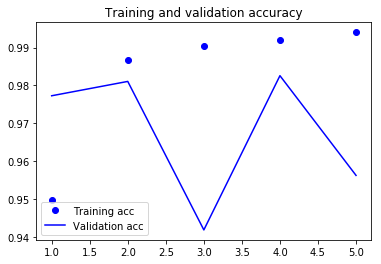

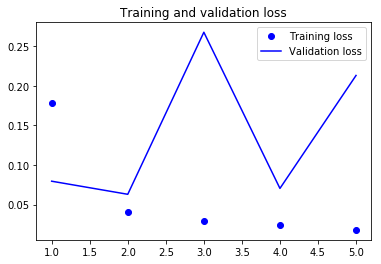

In [12]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [13]:
for each_layer in model.layers[:140]:
    each_layer.trainable = False
    
for each_layer in model.layers[140:]:
    each_layer.trainable = True

In [14]:
opt = optimizers.rmsprop(lr=1e-5)
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=[metrics.categorical_accuracy])

history = model.fit_generator(train_generator,
                              steps_per_epoch=595,
                              epochs=30,
                              validation_data=val_generator,
                              validation_steps=83)

model.save(str(pathlib.Path.cwd()) + "/models/" + "resnet50_keras_stage_2_group_NewSoftmax.h5")

Epoch 1/30
595/595 [==============================] - 476s 800ms/step - loss: 0.0079 - categorical_accuracy: 0.9975 - val_loss: 0.0761 - val_categorical_accuracy: 0.9803
Epoch 2/30
595/595 [==============================] - 464s 780ms/step - loss: 0.0039 - categorical_accuracy: 0.9987 - val_loss: 0.0655 - val_categorical_accuracy: 0.9831
Epoch 3/30
595/595 [==============================] - 464s 779ms/step - loss: 0.0031 - categorical_accuracy: 0.9991 - val_loss: 0.0677 - val_categorical_accuracy: 0.9837
Epoch 4/30
595/595 [==============================] - 466s 784ms/step - loss: 0.0024 - categorical_accuracy: 0.9993 - val_loss: 0.0608 - val_categorical_accuracy: 0.9862
Epoch 5/30
595/595 [==============================] - 464s 779ms/step - loss: 0.0021 - categorical_accuracy: 0.9993 - val_loss: 0.0636 - val_categorical_accuracy: 0.9845
Epoch 6/30
595/595 [==============================] - 464s 780ms/step - loss: 0.0016 - categorical_accuracy: 0.9996 - val_loss: 0.0587 - val_categoric

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



595/595 [==============================] - 464s 780ms/step - loss: 4.0669e-04 - categorical_accuracy: 0.9999 - val_loss: 0.0544 - val_categorical_accuracy: 0.9881
Epoch 26/30
595/595 [==============================] - 466s 783ms/step - loss: 2.6285e-04 - categorical_accuracy: 0.9999 - val_loss: 0.0590 - val_categorical_accuracy: 0.9882
Epoch 27/30
595/595 [==============================] - 465s 782ms/step - loss: 5.2185e-04 - categorical_accuracy: 0.9999 - val_loss: 0.0600 - val_categorical_accuracy: 0.9881
Epoch 28/30
595/595 [==============================] - 464s 779ms/step - loss: 2.6028e-04 - categorical_accuracy: 0.9999 - val_loss: 0.0549 - val_categorical_accuracy: 0.9898
Epoch 29/30
595/595 [==============================] - 465s 782ms/step - loss: 7.9275e-04 - categorical_accuracy: 0.9998 - val_loss: 0.0536 - val_categorical_accuracy: 0.9886
Epoch 30/30
578/595 [============================>.] - ETA: 12s - loss: 1.4880e-04 - categorical_accuracy: 1.0000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



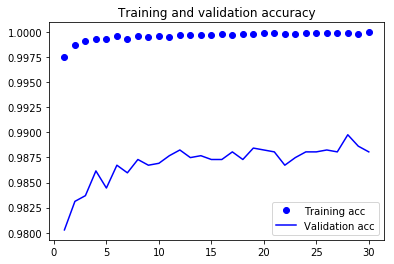

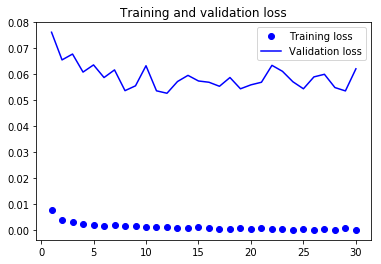

In [15]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()